<a href="https://colab.research.google.com/github/MangoHaha/NLP-dependency-parsing/blob/master/Dependency_Parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pyspark
 

    100% |████████████████████████████████| 193.9MB 80kB/s 
    100% |████████████████████████████████| 204kB 27.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/dc/0e/02/e9fdf0bf3ad20284175307d4ab31afcf967604f25f3b4f1d96
Successfully built pyspark


In [0]:
import pyspark
from pyspark import SparkContext
sc = SparkContext("local", "Data Prepare")

ImportError: ignored

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np


In [0]:
class DataSet:
  
  
  def __init__(self): 
    self.dev_data = pd.read_csv('/content/drive/My Drive/NLP/data/dev.data', sep=" ", header=None)
    self.train_data = pd.read_csv('/content/drive/My Drive/NLP/data/train.data', sep=" ", header=None)
    self.vocabs_action = pd.read_csv('/content/drive/My Drive/NLP/data/vocabs.actions', sep=" ", header=None)
    self.vocabs_pos = pd.read_csv('/content/drive/My Drive/NLP/data/vocabs.pos', sep=" ", header=None)
    self.vocabs_label = pd.read_csv('/content/drive/My Drive/NLP/data/vocabs.labels', sep=" ", header=None)
    self.vocabs_word = pd.read_csv('/content/drive/My Drive/NLP/data/vocabs.word', sep=" ", header=None)
    self.word_train = self.prepare_data(self.train_data, self.vocabs_word, 0, 20)
    self.pos_train = self.prepare_data(self.train_data, self.vocabs_pos, 20, 40)
    self.label_train = self.prepare_data(self.train_data, self.vocabs_label, 40, 52)
    self.action_train = self.prepare_data(self.train_data, self.vocabs_action, 52, 53)
    self.word_dev = self.prepare_data(self.dev_data, self.vocabs_word, 0, 20)
    self.pos_dev = self.prepare_data(self.dev_data, self.vocabs_pos, 20, 40)
    self.label_dev = self.prepare_data(self.dev_data, self.vocabs_label, 40, 52)
    self.action_dev = self.prepare_data(self.dev_data, self.vocabs_action, 52, 53)

  def prepare_data(self, data, vocabs, start, end):
    sub_data = data.iloc[:,start:end]
    voc = dict(zip(vocabs.iloc[:,0], vocabs.iloc[:,1]))
    new_array = []
    for line in sub_data.itertuples():
    #for line in sub_data.itertuples():
      cur_array = []
      for word in line[1:]:
        if word in voc:
          cur_array.append(voc.get(word))
        else:
          cur_array.append(0)
      new_array.append(cur_array)
    return pd.DataFrame(new_array)
  
  def prepare_data_predict(self, data, vocabs, start, end):
    sub_data = data[start:end]
    voc = dict(zip(vocabs.iloc[:,0], vocabs.iloc[:,1]))
    new_array = []
    #for line in sub_data.head(20).itertuples():
    for word in sub_data:
      if word in voc:
        new_array.append(voc.get(word))
      else:
        new_array.append(1)
    return pd.DataFrame(new_array)


In [0]:
from numpy import argmax
# integer encode input data
dataset = DataSet()
#print(dataset.word_train.values.tolist())
# one hot encode
#onehot_encoded = []
#for value in dataset.word_train.values.tolist():
#  for index in value:
#    letter = [0 for _ in range(len(dataset.vocabs_word))]
#    letter[index] = 1
#    onehot_encoded.append(letter)
#  print(value)

#print(len(onehot_encoded[0]))

word_oh_encoder = OneHotEncoder()
encoded_val = word_oh_encoder.word_oh_encoder(dataset.word_train.values.tolist()[0])
print(len(encoded_val[0]))

4807


In [0]:
from sklearn import preprocessing
x = [[2,3,4,5,6,7]]
print(x)
enc = preprocessing.OneHotEncoder()
enc.fit(x)
onehotlabels = enc.transform(x).toarray()
print(onehotlabels)

[[2, 3, 4, 5, 6, 7]]
[[1. 1. 1. 1. 1. 1.]]


In [0]:
class NetProperties:
    def __init__(self, word_embed_dim, pos_embed_dim, label_embed_dim, hidden_dim, minibatch_size, epoch):
        self.word_embed_dim = word_embed_dim
        self.pos_embed_dim = pos_embed_dim
        self.label_embed_dim = label_embed_dim
        self.hidden_dim = hidden_dim
        self.minibatch_size = minibatch_size
        self.epoch = epoch

In [14]:
!pip install dynet


     |████████████████████████████████| 27.9MB 1.7MB/s 


In [0]:
import dynet as dynet
import random
import matplotlib.pyplot as plt
import numpy as np

class Network:
    def __init__(self, properties, dataset):
        self.properties = properties
        self.dataset = dataset
        #self.tag2action = dict(zip(dataset.vocabs_action.iloc[:,1], dataset.vocabs_action.iloc[:,0]))


        # first initialize a computation graph container (or model).
        self.model = dynet.Model()

        # assign the algorithm for backpropagation updates.
        self.updater = dynet.AdamTrainer(self.model)

        # create embeddings for words and tag features.
        self.word_embedding = self.model.add_lookup_parameters((dataset.vocabs_word.shape[0], properties.word_embed_dim))
        self.pos_embedding = self.model.add_lookup_parameters((dataset.vocabs_pos.shape[0], properties.pos_embed_dim))
        self.label_embedding = self.model.add_lookup_parameters((dataset.vocabs_label.shape[0], properties.label_embed_dim))


        # assign transfer function 
        self.transfer = dynet.rectify  # can be dynet.logistic or dynet.tanh as well.

        # define the input dimension for the embedding layer.
        # here we assume to see two words after and before and current word (meaning 5 word embeddings)
        # and to see the last two predicted tags (meaning two tag embeddings)
        #self.input_dim = 5 * properties.word_embed_dim + 2 * properties.pos_embed_dim
        self.input_dim = 20 * (properties.word_embed_dim + properties.pos_embed_dim) + 12*properties.label_embed_dim


        # define the hidden layer.
        self.hidden_layer1 = self.model.add_parameters((properties.hidden_dim, self.input_dim))

        # define the hidden layer bias term and initialize it as constant 0.2.
        self.hidden_layer_bias1 = self.model.add_parameters(properties.hidden_dim, init=dynet.ConstInitializer(0.2))
        
        # define the hidden layer.
        self.hidden_layer2 = self.model.add_parameters((properties.hidden_dim, properties.hidden_dim))

        # define the hidden layer bias term and initialize it as constant 0.2.
        self.hidden_layer_bias2 = self.model.add_parameters(properties.hidden_dim, init=dynet.ConstInitializer(0.2))

        # define the output weight.
        self.output_layer = self.model.add_parameters((dataset.vocabs_action.shape[0], properties.hidden_dim))

        # define the bias vector and initialize it as zero.
        self.output_bias = self.model.add_parameters(dataset.vocabs_action.shape[0], init=dynet.ConstInitializer(0))

    def build_graph(self,index, word, pos, label):

        # extract word embeddings and tag embeddings from features
        word_embeds = [self.word_embedding[wid] for wid in word.iloc[index]]
        pos_embeds = [self.pos_embedding[wid] for wid in pos.iloc[index]]
        label_embeds = [self.label_embedding[wid] for wid in label.iloc[index]]

        # concatenating all features (recall that '+' for lists is equivalent to appending two lists)
        embedding_layer = dynet.concatenate(word_embeds + pos_embeds + label_embeds)
        # calculating the hidden layer
        # .expr() converts a parameter to a matrix expression in dynet (its a dynet-specific syntax).
        hidden1 = self.transfer(self.hidden_layer1 * embedding_layer + self.hidden_layer_bias1)
        hidden2 = self.transfer(self.hidden_layer2 * hidden1 + self.hidden_layer_bias2)

        # calculating the output layer
        output = self.output_layer * hidden2 + self.output_bias.expr()

        # return the output as a dynet vector (expression)
        return output

      
    def predict(self, word, pos, label):
 
        #word_oh = self.get_oh_encoder(word, dataset.vocabs_word.values.tolist())
    
        word_embeds = [self.word_embedding[wid] for wid in word]
        pos_embeds = [self.pos_embedding[wid] for wid in pos]
        label_embeds = [self.label_embedding[wid] for wid in label]
        # concatenating all features (recall that '+' for lists is equivalent to appending two lists)
        embedding_layer = dynet.concatenate(word_embeds + pos_embeds + label_embeds)
        # calculating the hidden layer
        # .expr() converts a parameter to a matrix expression in dynet (its a dynet-specific syntax).
        hidden1 = self.transfer(self.hidden_layer1 * embedding_layer + self.hidden_layer_bias1)
        hidden2 = self.transfer(self.hidden_layer2 * hidden1 + self.hidden_layer_bias2)

        # calculating the output layer
        output = self.output_layer.expr() * hidden2 + self.output_bias.expr()

        # return the output as a dynet vector (expression)
        return output
    def train(self):
        # matplotlib config
        loss_values = []
        plt.ion()
        ax = plt.gca()
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 3])
        plt.title("Loss over time")
        plt.xlabel("Minibatch")
        plt.ylabel("Loss")

        for i in range(self.properties.epoch):
            print 'started epoch', (i+1)
            losses = []

            step = 0
            for index in range(dataset.word_train.shape[0]):
                gold_label = dataset.action_train.iloc[index]
                result = self.build_graph(index, dataset.word_train, dataset.pos_train, dataset.label_train)

                # getting loss with respect to negative log softmax function and the gold label.
                loss = dynet.pickneglogsoftmax(result, gold_label)

                # appending to the minibatch losses
                losses.append(loss)
                step += 1
                #print("G" + gold_label)
                #print(result)
                #print(len(losses))
                if len(losses) >= self.properties.minibatch_size:
                    # now we have enough loss values to get loss for minibatch
                    minibatch_loss = dynet.esum(losses) / len(losses)

                    # calling dynet to run forward computation for all minibatch items
                    minibatch_loss.forward()

                    # getting float value of the loss for current minibatch
                    minibatch_loss_value = minibatch_loss.value()

                    # printing info and plotting
                    loss_values.append(minibatch_loss_value)
                    if len(loss_values)%10==0:
                        ax.set_xlim([0, len(loss_values)+10])
                        ax.plot(loss_values)
                        plt.draw()
                        plt.pause(0.0001)
                        progress = round(100 * float(step) / len(dataset.train_data), 2)
                        print 'current minibatch loss', minibatch_loss_value, 'progress:', progress, '%'

                    # calling dynet to run backpropagation
                    minibatch_loss.backward()

                    # calling dynet to change parameter values with respect to current backpropagation
                    self.updater.update()

                    # empty the loss vector
                    losses = []

                    # refresh the memory of dynet
                    dynet.renew_cg()

            # there are still some minibatch items in the memory but they are smaller than the minibatch size
            # so we ask dynet to forget them
            dynet.renew_cg()

    def decode(self, word_dev, pos_dev, label_dev):
        # first putting two start symbols
        #tags = ['<s>', '<s>']

            # running forward
        word_dev.values.reshape(-1)
        output = self.predict(word_dev.values.reshape(-1).tolist(), pos_dev.values.reshape(-1).tolist(), label_dev.values.reshape(-1).tolist())

            # getting list value of the output
        scores = output.npvalue()

            # getting best tag
        #best_tag_id = np.argmax(scores)

            # assigning the best tag
        #tags.append(tag2action.get(best_tag_id))

            # refresh dynet memory (computation graph)
        dynet.renew_cg()

        return scores
    
    def get_oh_encoder(self, input, vocabs):
      onehot_encoded = []
      for index in input:
        letter = [0 for _ in range(len(vocabs))]
        letter[index] = 1
        onehot_encoded.append(letter)
      return onehot_encoded;

    def load(self, filename):
        self.model.populate(filename)

    def save(self, filename):
        self.model.save(filename)

started epoch 1


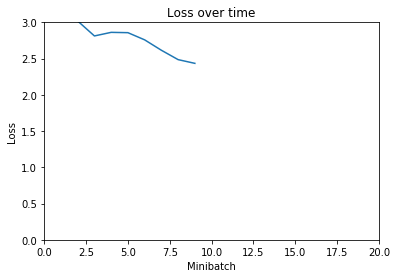

current minibatch loss 2.43445611 progress: 6.96 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 2.05592131615 progress: 13.91 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 1.76919448376 progress: 20.87 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 1.64815282822 progress: 27.82 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 1.35564386845 progress: 34.78 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 1.11026263237 progress: 41.74 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 1.05354964733 progress: 48.69 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.840351045132 progress: 55.65 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.791448116302 progress: 62.61 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.64462429285 progress: 69.56 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.661213517189 progress: 76.52 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.527420163155 progress: 83.47 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.470874190331 progress: 90.43 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.461513906717 progress: 97.39 %
started epoch 2


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.373359233141 progress: 4.87 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.381418943405 progress: 11.83 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.390094339848 progress: 18.78 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.353747725487 progress: 25.74 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.393706530333 progress: 32.69 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.259532421827 progress: 39.65 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.315029889345 progress: 46.61 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.365210682154 progress: 53.56 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.252369910479 progress: 60.52 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.312573134899 progress: 67.47 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.266790449619 progress: 74.43 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.195354282856 progress: 81.39 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.285845041275 progress: 88.34 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.236081257463 progress: 95.3 %
started epoch 3


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.38811314106 progress: 2.78 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.256184458733 progress: 9.74 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.217553421855 progress: 16.69 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.295651257038 progress: 23.65 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.211281016469 progress: 30.61 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.256590783596 progress: 37.56 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.236314252019 progress: 44.52 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.210850849748 progress: 51.48 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.219599545002 progress: 58.43 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.242462828755 progress: 65.39 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.20126478374 progress: 72.34 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.211692869663 progress: 79.3 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.145203053951 progress: 86.26 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.180209353566 progress: 93.21 %
started epoch 4


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.194068565965 progress: 0.7 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.27520313859 progress: 7.65 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.166086271405 progress: 14.61 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.17800450325 progress: 21.56 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.149478703737 progress: 28.52 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.185592636466 progress: 35.48 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.187558993697 progress: 42.43 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.198002547026 progress: 49.39 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.164739906788 progress: 56.34 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.211269125342 progress: 63.3 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.170063376427 progress: 70.26 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.145872429013 progress: 77.21 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.209629014134 progress: 84.17 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.155654549599 progress: 91.13 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.123572826385 progress: 98.08 %
started epoch 5


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.18303476274 progress: 5.56 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.153792589903 progress: 12.52 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.163662970066 progress: 19.48 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.148206874728 progress: 26.43 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.0993551313877 progress: 33.39 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.122204482555 progress: 40.35 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.164488881826 progress: 47.3 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.156613379717 progress: 54.26 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.166958332062 progress: 61.21 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.148876935244 progress: 68.17 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.125720188022 progress: 75.13 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.130760446191 progress: 82.08 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.151893660426 progress: 89.04 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.0939700603485 progress: 95.99 %
started epoch 6


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.140247091651 progress: 3.48 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.188433364034 progress: 10.43 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.232748255134 progress: 17.39 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.136047258973 progress: 24.35 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.131533756852 progress: 31.3 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.140819177032 progress: 38.26 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.142833307385 progress: 45.21 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.164937093854 progress: 52.17 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.128418087959 progress: 59.13 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.113278217614 progress: 66.08 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.150372684002 progress: 73.04 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.0934808403254 progress: 80.0 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.0800439566374 progress: 86.95 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.101732611656 progress: 93.91 %
started epoch 7


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.118239507079 progress: 1.39 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.0925229564309 progress: 8.35 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.0950957387686 progress: 15.3 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.0908848494291 progress: 22.26 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.137527957559 progress: 29.22 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.0852422043681 progress: 36.17 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.128325045109 progress: 43.13 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.0700156837702 progress: 50.08 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.0830074697733 progress: 57.04 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.120910353959 progress: 64.0 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.096031576395 progress: 70.95 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.0973019301891 progress: 77.91 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.0815668031573 progress: 84.86 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.0537418089807 progress: 91.82 %


<Figure size 432x288 with 0 Axes>

current minibatch loss 0.0742615759373 progress: 98.78 %


In [0]:
prop = NetProperties(64, 32, 32, 200, 1000, 7)
dataset = DataSet();
network = Network(prop, dataset)
network.train()
network.save("/content/drive/My Drive/NLP/model.md5")

In [0]:
network.load("/content/drive/My Drive/NLP/model.md5")
tag2action = dict(zip(dataset.vocabs_action.iloc[:,1], dataset.vocabs_action.iloc[:,0]))
network.decode(dataset.word_dev.values.tolist()[0], dataset.pos_dev.values.tolist()[0], dataset.label_dev.values.tolist()[0])

AttributeError: ignored

In [0]:
class DepModel:
    def __init__(self):
        '''
            You can add more arguments for examples actions and model paths.
            You need to load your model here.
            actions: provides indices for actions.
            it has the same order as the data/vocabs.actions file.
        '''
        # if you prefer to have your own index for actions, change this.
        self.actions = ['SHIFT', 'LEFT-ARC:rroot', 'LEFT-ARC:cc', 'LEFT-ARC:number', 'LEFT-ARC:ccomp', 'LEFT-ARC:possessive', 'LEFT-ARC:prt', 'LEFT-ARC:num', 'LEFT-ARC:nsubjpass', 'LEFT-ARC:csubj', 'LEFT-ARC:conj', 'LEFT-ARC:dobj', 'LEFT-ARC:nn', 'LEFT-ARC:neg', 'LEFT-ARC:discourse', 'LEFT-ARC:mark', 'LEFT-ARC:auxpass', 'LEFT-ARC:infmod', 'LEFT-ARC:mwe', 'LEFT-ARC:advcl', 'LEFT-ARC:aux', 'LEFT-ARC:prep', 'LEFT-ARC:parataxis', 'LEFT-ARC:nsubj', 'LEFT-ARC:<null>', 'LEFT-ARC:rcmod', 'LEFT-ARC:advmod', 'LEFT-ARC:punct', 'LEFT-ARC:quantmod', 'LEFT-ARC:tmod', 'LEFT-ARC:acomp', 'LEFT-ARC:pcomp', 'LEFT-ARC:poss', 'LEFT-ARC:npadvmod', 'LEFT-ARC:xcomp', 'LEFT-ARC:cop', 'LEFT-ARC:partmod', 'LEFT-ARC:dep', 'LEFT-ARC:appos', 'LEFT-ARC:det', 'LEFT-ARC:amod', 'LEFT-ARC:pobj', 'LEFT-ARC:iobj', 'LEFT-ARC:expl', 'LEFT-ARC:predet', 'LEFT-ARC:preconj', 'LEFT-ARC:root', 'RIGHT-ARC:rroot', 'RIGHT-ARC:cc', 'RIGHT-ARC:number', 'RIGHT-ARC:ccomp', 'RIGHT-ARC:possessive', 'RIGHT-ARC:prt', 'RIGHT-ARC:num', 'RIGHT-ARC:nsubjpass', 'RIGHT-ARC:csubj', 'RIGHT-ARC:conj', 'RIGHT-ARC:dobj', 'RIGHT-ARC:nn', 'RIGHT-ARC:neg', 'RIGHT-ARC:discourse', 'RIGHT-ARC:mark', 'RIGHT-ARC:auxpass', 'RIGHT-ARC:infmod', 'RIGHT-ARC:mwe', 'RIGHT-ARC:advcl', 'RIGHT-ARC:aux', 'RIGHT-ARC:prep', 'RIGHT-ARC:parataxis', 'RIGHT-ARC:nsubj', 'RIGHT-ARC:<null>', 'RIGHT-ARC:rcmod', 'RIGHT-ARC:advmod', 'RIGHT-ARC:punct', 'RIGHT-ARC:quantmod', 'RIGHT-ARC:tmod', 'RIGHT-ARC:acomp', 'RIGHT-ARC:pcomp', 'RIGHT-ARC:poss', 'RIGHT-ARC:npadvmod', 'RIGHT-ARC:xcomp', 'RIGHT-ARC:cop', 'RIGHT-ARC:partmod', 'RIGHT-ARC:dep', 'RIGHT-ARC:appos', 'RIGHT-ARC:det', 'RIGHT-ARC:amod', 'RIGHT-ARC:pobj', 'RIGHT-ARC:iobj', 'RIGHT-ARC:expl', 'RIGHT-ARC:predet', 'RIGHT-ARC:preconj', 'RIGHT-ARC:root']
        # write your code here for additional parameters.
        # feel free to add more arguments to the initializer.
        prop = NetProperties(64, 32, 32, 200, 1000, 7)
        dataset = DataSet();
        self.network = Network(prop, dataset)

        self.network.load("/content/drive/My Drive/NLP/model.md5")
        self.data = DataSet()

    def score(self, str_features):
        '''
        :param str_features: String features
        20 first: words, next 20: pos, next 12: dependency labels.
        DO NOT ADD ANY ARGUMENTS TO THIS FUNCTION.
        :return: list of scores
        '''
        # change this part of the code.
        word = self.data.prepare_data_predict(str_features, self.data.vocabs_word, 0, 20)
        pos = self.data.prepare_data_predict(str_features, self.data.vocabs_pos, 20, 40)
        label = self.data.prepare_data_predict(str_features, self.data.vocabs_label, 40, 52)
        #return [0]*len(self.actions)
        scores = self.network.decode(word, pos, label)
        #scores = np.reshape(scores,[len(self.actions)])
        #print(scores.tolist())
        return scores.tolist()

In [0]:
class Decoder:
    def __init__(self, score_fn, rindex):
        self.fn = score_fn
        self.map = rindex

    def parse(self, f, of):
        outputs = []
        for k, sen in enumerate(read_conll(f)):
            #print(type(sen))
            conf = Configuration.parse(sen, self.map, self.fn)
            for i, arc in enumerate(conf.arcs[1:]):
               sen[i + 1].head, sen[i+1].relation = arc[0], arc[1]
            outputs.append(sen)
            #print(str(sen))
            if (k + 1) % 100 == 0:
                sys.stdout.write(str(k + 1) + '...')
        sys.stdout.write('\n')
        write_conll(of, outputs)

In [0]:
class Configuration:
    def __init__(self, entries):
        self.stack = [0]
        self.entries = entries
        self.buffer = [e.id for e in entries[1:]]
        #print(self.buffer)
        self.arcs = [(-1, '') for _ in entries]
        self.lm = [-1 for _ in entries]  # left-most modifier
        self.rm = [-1 for _ in entries]  # right-most modifier
        self.lm2 = [-1 for _ in entries]  # 2nd left-most modifier
        self.rm2 = [-1 for _ in entries]  # 2nd right-most modifier

    def next_gold_action(self):
        if len(self.stack) < 2:
            assert len(self.buffer)>0
            return 'SHIFT', None
        else:
            s0 = self.stack[-1] if len(self.stack) > 0 else None
            s1 = self.stack[-2] if len(self.stack) > 1 else None

            if s0 == self.entries[s1].head:
                return 'LEFT-ARC', self.entries[s1].relation
            elif s1 == self.entries[s0].head:
                valence_complete = True
                for j in self.buffer:
                    if self.entries[j].head == s0:
                        valence_complete = False
                        break
                if valence_complete:
                    return 'RIGHT-ARC', self.entries[s0].relation
                else:
                    assert len(self.buffer) > 0
                    return 'SHIFT', None
            else:
                assert len(self.buffer) > 0
                return 'SHIFT', None

    def do(self, action, label=''):
        if action == 'SHIFT':
            self.stack.append(self.buffer.pop(0))
        elif action == 'RIGHT-ARC':
            if self.rm[self.stack[-2]] != -1:
                self.rm2[self.stack[-2]] = self.rm[self.stack[-2]]
            self.rm[self.stack[-2]] = self.stack[-1]
            self.arcs[self.stack[-1]] = self.stack[-2], label
            self.stack.pop(-1)
        elif action == 'LEFT-ARC':
            if self.lm[self.stack[-1]] == -1 or self.lm[self.stack[-1]] > self.stack[-2]:
                if self.lm[self.stack[-1]] != -1:
                    self.lm2[self.stack[-1]] = self.lm[self.stack[-1]]
                self.lm[self.stack[-1]] = self.stack[-2]
            self.arcs[self.stack[-2]] = self.stack[-1], label
            self.stack.pop(-2)

    def doable_actions(self):
        actions = set()
        if len(self.buffer) > 0:
            actions.add('SHIFT')
        if len(self.stack) >= 2:
            actions.add('RIGHT-ARC')
        if len(self.stack) >= 2 and self.stack[-2] != 0:
            actions.add('LEFT-ARC')
        return actions

    def is_terminal_state(self):
        return len(self.stack) == 1 and len(self.buffer) == 0

    def feature_ids(self):
        s0 = self.stack[-1] if len(self.stack) > 0 else None
        s1 = self.stack[-2] if len(self.stack) > 1 else None
        s2 = self.stack[-3] if len(self.stack) > 2 else None
        s3 = self.stack[-4] if len(self.stack) > 3 else None
        b0 = self.buffer[0] if len(self.buffer) > 0 else None
        b1 = self.buffer[1] if len(self.buffer) > 1 else None
        b2 = self.buffer[2] if len(self.buffer) > 2 else None
        b3 = self.buffer[3] if len(self.buffer) > 3 else None
        s0l = self.lm[s0] if s0 and self.lm[s0] > -1 else None
        s1l = self.lm[s1] if s1 and self.lm[s1] > -1 else None
        s0r = self.rm[s0] if s0 and self.rm[s0] > -1 else None
        s1r = self.rm[s1] if s1 and self.rm[s1] > -1 else None
        s0l2 = self.lm2[s0] if s0 and self.lm2[s0] > -1 else None
        s1l2 = self.lm2[s1] if s1 and self.lm2[s1] > -1 else None
        s0r2 = self.rm2[s0] if s0 and self.rm2[s0] > -1 else None
        s1r2 = self.rm2[s1] if s1 and self.rm2[s1] > -1 else None
        s0r1r1 = self.rm[s0r] if s0r and self.rm[s0r]>-1 else None
        s1r1r1 = self.rm[s1r] if s1r and self.rm[s1r]>-1 else None
        s0l1l1 = self.lm[s0l] if s0l and self.lm[s0l] > -1 else None
        s1l1l1 = self.lm[s1l] if s1l and self.lm[s1l] > -1 else None
        return [s0,s1,s2,s3,b0,b1,b2,b3,s0l,s1l,s0r,s1r,s0l2,s1l2,s0r2,s1r2,s0r1r1,s1r1r1,s0l1l1,s1l1l1]

    def features(self):
        feats = self.feature_ids()
        word_feats, pos_feats, label_feats = [], [], []
        for i,f in enumerate(feats):
            word_feats.append(self.entries[f].form) if f is not None else word_feats.append('<null>')
            pos_feats.append(self.entries[f].pos) if f is not None else pos_feats.append('<null>')
            if i>=8:
                label_feats.append(self.arcs[f][1]) if f and self.arcs[f][0]!=-1 is not None else label_feats.append('<null>')
        return word_feats, pos_feats, label_feats

    def preprocess_score(self, scores, rlabel):
        '''
        With respect to possible actions
        :param scores:
        :return:
        '''
        da = self.doable_actions()
        can_shift = True if 'SHIFT' in da else False
        can_left_arc = True if 'LEFT-ARC' in da else False
        can_right_arc = True if 'RIGHT-ARC' in da else False
        for i in range(len(scores)):
            if not can_shift and rlabel[i] == 'SHIFT':
                scores[i] = -float('inf')
            elif not can_left_arc and rlabel[i].startswith('LEFT-ARC'):
                scores[i] = -float('inf')
            elif not can_right_arc and rlabel[i].startswith('RIGHT-ARC'):
                scores[i] = -float('inf')

    @staticmethod
    def parse(sen, rlabel, score_fn):
        conf = Configuration(sen)
        while not conf.is_terminal_state():
            wf, pf, lf = conf.features()
            scores = score_fn(wf + pf + lf)
            conf.preprocess_score(scores, rlabel)
            best_act = np.argmax(scores)
            act, label = 'SHIFT', ''
            if rlabel[best_act] != 'SHIFT':
                act, label = rlabel[best_act].split(':')
            conf.do(act, label)
        return conf

In [0]:
import re, codecs
class DependencyToken:
    def __init__(self, id, form, lemma, pos, cpos, feats=None, parent_id=None, relation=None, deps=None, misc=None):
        self.id = id
        self.form = form
        self.norm = normalize(form)
        self.cpos = cpos
        self.pos = pos
        self.head = parent_id
        self.relation = relation

        self.lemma = lemma
        self.feats = feats
        self.deps = deps
        self.misc = misc

    def __str__(self):
        values = [str(self.id), self.form, self.lemma, self.cpos, self.pos, self.feats,
                  str(self.head), self.relation, self.deps, self.misc]
        return u'\t'.join([u'_' if v is None else v for v in values])


def traverse(rev_head, h, visited):
    if rev_head.has_key(h):
        for d in rev_head[h]:
            if d in visited:
                return True
            visited.append(d)
            traverse(rev_head, d, visited)
    return False


def is_projective(heads):
    '''
    Decides if the set of heads for tree is projective.
    :param heads:
    :return: True if projective, else False.
    '''
    rev_head = defaultdict(list)
    for dep1 in range(1, len(heads) + 1):
        head1 = heads[dep1 - 1]
        if head1 >= 0:
            rev_head[head1].append(dep1)

    visited = list()
    if traverse(rev_head, 0, visited):
        return False
    if len(visited) < len(heads):
        return False

    root_n = 0
    for dep1 in range(1, len(heads) + 1):
        head1 = heads[dep1 - 1]

        if rev_head.has_key(dep1):
            for d2 in rev_head[dep1]:
                if (d2 < head1 < dep1) or (d2 > head1 > dep1) and head1 > 0:
                    return False

        if head1 == 0:
            root_n += 1
        for dep2 in range(1, len(heads) + 1):
            head2 = heads[dep2 - 1]
            if head1 == -1 or head2 == -1:
                continue
            if dep1 > head1 != head2:
                if dep2 > dep1 > head2 > head1:
                    return False
                if head2 > dep1 > dep2 > head1:
                    return False
            if dep1 < head1 != head2:
                if dep2 > head1 > head2 > dep1:
                    return False
                if head2 > head1 > dep2 > dep1:
                    return False
    if root_n != 1:
        return False
    return True


def read_conll(fh, test=False):
    '''
    This function reads a CoNLL file and returns a list of @ConllEntry objects.
    :param fh: file
    :return: a list of @ConllEntry objects
    '''
    root = DependencyToken(0, '<root>', '<root>', '<root>', '<root>', '_', -1, 'rroot', '_', '_')
    tokens = [root]
    for line in codecs.open(fh, 'r', encoding='UTF-8'):
        tok = line.strip().split('\t')
        if not tok or line.strip() == '':
            if len(tokens) > 1: yield tokens
            tokens = [root]
        else:
            if line[0] == '#' or '-' in tok[0] or '.' in tok[0]:
                tokens.append(line.strip())
            else:
                tokens.append(DependencyToken(int(tok[0]), tok[1], tok[2], tok[3], tok[4], tok[5],
                                             -1 if test else int(tok[6]) if tok[6] != '_' else -1,'_'  if test else tok[7], tok[8], tok[9]))
    if len(tokens) > 1:
        yield tokens


def write_conll(fn, conll_gen):
    '''
    Writes a conll file
    :param fn: output path.
    :param conll_gen: Generator for conll file (a list of @ConllEntry objects).
    :return:
    '''
    with codecs.open(fn, 'w', encoding='utf-8') as fh:
        for sentence in conll_gen:
            for entry in sentence[1:]:
                fh.write(str(entry) + u'\n')
            fh.write('\n')


def eval(gold, predicted):
    '''
    Evaluates the output vs. gold.
    :param gold: Gold Conll file.
    :param predicted: Predicted Conll file.
    :return: Unlabeled attachment accuracy (UAS), labeled attachment accuracy (LAS).
    '''
    correct_deps, correct_l, all_deps = 0, 0, 0
    r2 = open(predicted, 'r')
    for l1 in open(gold, 'r'):
        s1 = l1.strip().split('\t')
        s2 = r2.readline().strip().split('\t')
        if len(s1) > 6:
            if not is_punc(s2[3]):
                all_deps += 1
                if s1[6] == s2[6]:
                    correct_deps += 1
                    if s1[7] == s2[7]:
                        correct_l += 1
    return 100 * float(correct_deps) / all_deps, 100 * float(correct_l) / all_deps


numberRegex = re.compile("[0-9]+|[0-9]+\\.[0-9]+|[0-9]+[0-9,]+");


def normalize(word):
    return 'NUM' if numberRegex.match(word) else word.lower()


def is_punc(pos):
    return pos == '.' or pos == 'PUNC' or pos == 'PUNCT' or \
           pos == "#" or pos == "''" or pos == "(" or \
           pos == "[" or pos == "]" or pos == "{" or pos == "}" or \
           pos == "\"" or pos == "," or pos == "." or pos == ":" or \
           pos == "``" or pos == "-LRB-" or pos == "-RRB-" or pos == "-LSB-" or \
           pos == "-RSB-" or pos == "-LCB-" or pos == "-RCB-" or pos == '"' or pos == ')'

In [15]:
import sys
input_p = "/content/drive/My Drive/NLP/trees/dev.conll"
output_p = "/content/drive/My Drive/NLP/output_dev"
dataset = DataSet()
tag2action = dict(zip(dataset.vocabs_action.iloc[:,1], dataset.vocabs_action.iloc[:,0]))

m = DepModel()
Decoder(m.score, m.actions).parse(input_p, output_p)

100...200...300...400...500...600...700...800...900...1000...1100...1200...1300...1400...1500...1600...1700...
